In [34]:
import boto3
import json
from io import StringIO
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import joblib

In [35]:
# S3 Bucket and data location
S3_BUCKET = "fraud-detection-storage-mk"
S3_KEY = "synthetic-transaction-data/transactions.json"

# Load data from S3
s3 = boto3.client("s3")
obj = s3.get_object(Bucket=S3_BUCKET, Key=S3_KEY)
data = obj["Body"].read().decode("utf-8")
df = pd.read_json(StringIO(data))
df.head()

,transaction_id,user_id,timestamp,amount,device_type,location,is_vpn,card_type,status,is_fraud
0,T4048,U83310,2025-01-01 12:00:00+00:00,2917.55,desktop,C,False,credit,approved,0
1,T2663,U17909,2025-01-01 12:00:00+00:00,284.67,mobile,C,False,credit,approved,0
2,T7547,U68247,2025-01-01 12:00:00+00:00,1193.47,desktop,A,False,credit,approved,0
3,T4500,U23022,2025-01-01 12:00:00+00:00,3227.20,mobile,D,True,credit,approved,0
4,T5000,U13432,2025-01-01 12:00:00+00:00,49.61,mobile,F,True,debit,approved,0


In [36]:
# Feature Extraction
# Handle missing values
df.fillna(0, inplace=True)

# Encode categorical features
categorical_cols = ["location", "device_type", "card_type","is_vpn","status"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le




# Scale numerical features
numerical_cols = ["amount"]
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


# Drop non-numeric columns that are not needed for training
df.drop(columns=["transaction_id", "user_id", "timestamp"], inplace=True, errors='ignore')
df.head()


,amount,device_type,location,is_vpn,card_type,status,is_fraud
0,0.388078,0,2,0,0,0,0
1,0.036340,1,2,0,0,0,0
2,0.157751,0,0,0,0,0,0
3,0.429446,1,3,1,0,0,0
4,0.004938,1,5,1,1,0,0


In [37]:
df.head()

,amount,device_type,location,is_vpn,card_type,status,is_fraud
0,0.388078,0,2,0,0,0,0
1,0.036340,1,2,0,0,0,0
2,0.157751,0,0,0,0,0,0
3,0.429446,1,3,1,0,0,0
4,0.004938,1,5,1,1,0,0


In [38]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shapes of the splits
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print(df.dtypes)

Training data shape: (1600, 6)
Testing data shape: (400, 6)
amount         float64
device_type      int64
location         int64
is_vpn           int64
card_type        int64
status           int64
is_fraud         int64
dtype: object


In [39]:

# Train XGBoost Model with Hyperparameter Tuning
xgb_model = XGBClassifier(
    n_estimators=50,  
    max_depth=4,  
    learning_rate=0.05,  
    min_child_weight=10,  # Ensures splits happen only if enough data exists
    subsample=0.7,  # Randomly selects 70% of the data for training
    colsample_bytree=0.7,  # Uses 70% of features for each tree
    random_state=42
)

In [40]:
xgb_model.fit(X_train, y_train)

# Make Predictions
y_pred = xgb_model.predict(X_test)

y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("Classification Report:\n", report)

# Perform Cross-Validation
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring="accuracy")
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Model Accuracy: 0.9625
ROC-AUC Score: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96       200
           1       0.93      1.00      0.96       200

    accuracy                           0.96       400
   macro avg       0.97      0.96      0.96       400
weighted avg       0.97      0.96      0.96       400

Cross-Validation Accuracy Scores: [0.9775 0.9725 0.9775 0.9825 0.97  ]
Mean Accuracy: 0.976


In [41]:
# Save Model
model_filename = "fraud_detection_xgb.pkl"
joblib.dump(xgb_model, model_filename)
print(f"Model saved as {model_filename}")

Model saved as fraud_detection_xgb.pkl


In [42]:
# Upload Model to S3 for Deployment
s3.upload_file(model_filename, S3_BUCKET, f"models/{model_filename}")
print(f"Model uploaded to S3: s3://{S3_BUCKET}/models/{model_filename}")

Model uploaded to S3: s3://fraud-detection-storage-mk/models/fraud_detection_xgb.pkl


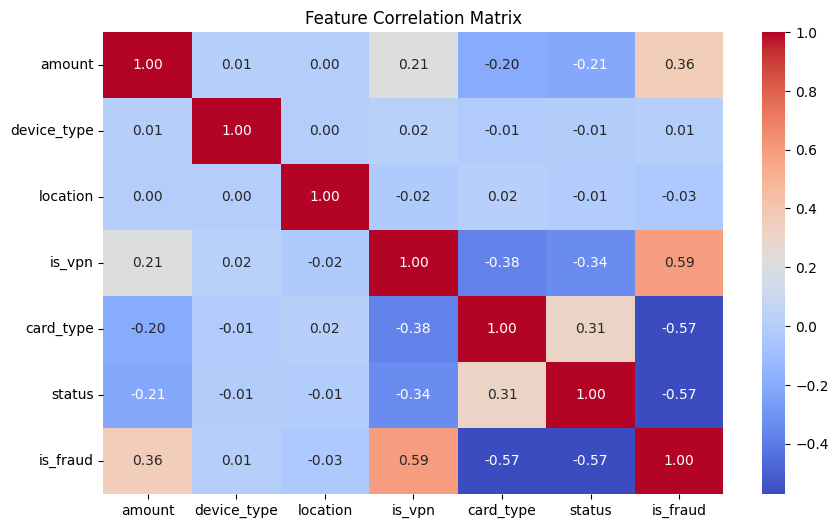

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()